In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch.nn.functional as F

In [2]:
# Function to load data from a single CSV file and reshape it
def load_single_file(file_path):
    try:
        # Read the CSV file
        data = pd.read_csv(file_path)
        # Ensure data is sorted by frame and point to maintain consistent ordering
        data_sorted = data.sort_values(by=['frame', 'point'])
        # Drop the 'frame' and 'point' columns and only keep the x, y, z coordinates
        data_points = data_sorted.drop(['frame', 'point'], axis=1)
        # Check if the data can be divided into chunks of 33 points
        if len(data_points) % 33 != 0:
            raise ValueError(f"Data length in {file_path} is not a multiple of 33")
        # Reshape data into (num_frames, 33, 3)
        num_frames = len(data_points) // 33
        reshaped_data = data_points.values.reshape((num_frames, 33, 3))
        return reshaped_data
    except FileNotFoundError as e:
        print(f"File not found: {file_path}")
        raise e
    except ValueError as e:
        print(f"Error processing file: {file_path}, {e}")
        raise e

In [3]:
class_names = [
    'backward', 'do nothing', 'forward', 'land', 
    'left', 'right', 'takeoff', 'up' 
]

base_directory = '../Fine Tune Dataset/'

all_data = []
all_labels = []

for class_index, class_name in enumerate(class_names):
    file_name = class_name.replace(" ", "_") + "100.csv"
    file_path = os.path.join(base_directory, file_name)
    try:
        class_data = load_single_file(file_path)
        for frame_data in class_data:
            all_data.append(frame_data)
            all_labels.append(class_index)
    except Exception as e:
        print(f"An error occurred for class '{class_name}': {str(e)}")

# Convert data and labels into numpy arrays and one-hot encode labels
X = np.array(all_data, dtype=np.float32)
y = np.eye(len(class_names))[np.array(all_labels)]

X.shape, y.shape

((800, 33, 3), (800, 8))

In [4]:
# Print the shape of the data and labels
print("Data shape:", X.shape)
print("Labels shape:", y.shape)

# Print the first 5 entries of the data and labels
print("data entries:\n", X[100,0])
print("labels:", y[195:205])

Data shape: (800, 33, 3)
Labels shape: (800, 8)
data entries:
 [ 0.4727822   0.22505957 -0.16590285]
labels: [[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


In [5]:
# Split the dataset into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [6]:
class PoseDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = torch.from_numpy(labels).float()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

# Define transform
transform = transforms.Compose([transforms.ToTensor()])

# Create datasets
train_dataset = PoseDataset(X_train, y_train, transform)
test_dataset = PoseDataset(X_test, y_test, transform)
val_dataset = PoseDataset(X_val, y_val, transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [7]:
# Check the size of the datasets
len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)

(640, 80, 80)

In [8]:
# Benchmark model
class BenchmarkModel(nn.Module):
    def __init__(self):
        super(BenchmarkModel, self).__init__()
        self.fc = nn.Linear(33 * 3, 8)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the tensor
        return self.fc(x)

In [9]:
# Initialize the model and hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BenchmarkModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.003)

In [10]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    corrects = 0

    for batch in train_loader:
        data, target = batch
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.size(0)
        preds = torch.sigmoid(outputs).data > 0.5  # Convert to binary predictions
        corrects += preds.eq(target.data).sum()

    return total_loss / len(train_loader.dataset), corrects.double() / (len(train_loader.dataset) * target.size(1))

# Test function
def test(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    corrects = 0

    with torch.no_grad():
        for batch in test_loader:
            data, target = batch
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item() * data.size(0)
            preds = torch.sigmoid(outputs).data > 0.5  # Convert to binary predictions
            corrects += preds.eq(target.data).sum()

    return total_loss / len(test_loader.dataset), corrects.double() / (len(test_loader.dataset) * target.size(1))



In [11]:
# Lists to collect losses and accuracies for each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

total_epochs = 0
total_time = 0

Epoch 1, Train Loss: 0.7704, Train Accuracy: 0.3783, Valid Loss: 0.7612, Valid Accuracy: 0.4016
Epoch 2, Train Loss: 0.7578, Train Accuracy: 0.4174, Valid Loss: 0.7490, Valid Accuracy: 0.4453
Epoch 3, Train Loss: 0.7457, Train Accuracy: 0.4543, Valid Loss: 0.7372, Valid Accuracy: 0.4672
Epoch 4, Train Loss: 0.7340, Train Accuracy: 0.4754, Valid Loss: 0.7258, Valid Accuracy: 0.4859
Epoch 5, Train Loss: 0.7227, Train Accuracy: 0.4941, Valid Loss: 0.7149, Valid Accuracy: 0.5062
Epoch 6, Train Loss: 0.7117, Train Accuracy: 0.5232, Valid Loss: 0.7043, Valid Accuracy: 0.5344
Epoch 7, Train Loss: 0.7012, Train Accuracy: 0.5463, Valid Loss: 0.6941, Valid Accuracy: 0.5500
Epoch 8, Train Loss: 0.6910, Train Accuracy: 0.5672, Valid Loss: 0.6842, Valid Accuracy: 0.5625
Epoch 9, Train Loss: 0.6812, Train Accuracy: 0.5805, Valid Loss: 0.6747, Valid Accuracy: 0.5781
Epoch 10, Train Loss: 0.6718, Train Accuracy: 0.5912, Valid Loss: 0.6655, Valid Accuracy: 0.5828
Epoch 11, Train Loss: 0.6626, Train Acc

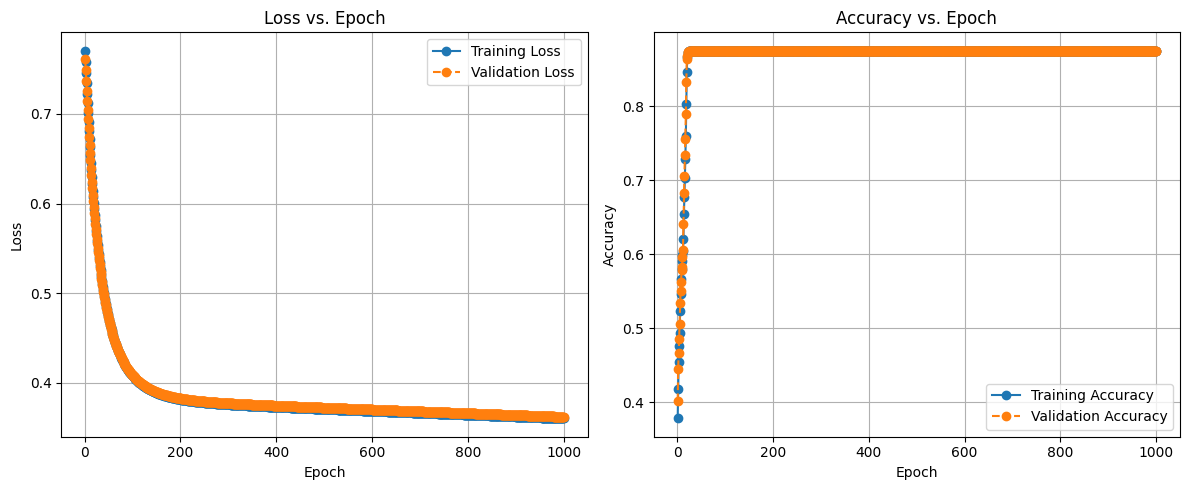

In [12]:
for epoch in range(1, 1001):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = test(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [17]:
#Deeper FC model
class Deep_FC_Model(nn.Module):
    def __init__(self):
        super(Deep_FC_Model, self).__init__()
        self.fc1 = nn.Linear(33 * 3, 32)  # First fully connected layer
        self.fc2 = nn.Linear(32, 8)       # Output layer with 8 units for 8 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)         # Flatten the tensor
        x = F.relu(self.fc1(x))           # Apply ReLU activation function
        x = self.fc2(x)                   # No activation, if using BCEWithLogitsLoss
        return x

# Initialize the model and hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Deep_FC_Model().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.003)

# Lists to collect losses and accuracies for each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

total_epochs = 0
total_time = 0

Epoch 1, Train Loss: 0.7078, Train Accuracy: 0.3984, Valid Loss: 0.7072, Valid Accuracy: 0.3891
Epoch 2, Train Loss: 0.7044, Train Accuracy: 0.4109, Valid Loss: 0.7039, Valid Accuracy: 0.4047
Epoch 3, Train Loss: 0.7011, Train Accuracy: 0.4271, Valid Loss: 0.7007, Valid Accuracy: 0.4203
Epoch 4, Train Loss: 0.6980, Train Accuracy: 0.4408, Valid Loss: 0.6977, Valid Accuracy: 0.4297
Epoch 5, Train Loss: 0.6950, Train Accuracy: 0.4510, Valid Loss: 0.6948, Valid Accuracy: 0.4453
Epoch 6, Train Loss: 0.6921, Train Accuracy: 0.4623, Valid Loss: 0.6919, Valid Accuracy: 0.4547
Epoch 7, Train Loss: 0.6894, Train Accuracy: 0.4768, Valid Loss: 0.6892, Valid Accuracy: 0.4766
Epoch 8, Train Loss: 0.6867, Train Accuracy: 0.4904, Valid Loss: 0.6866, Valid Accuracy: 0.4875
Epoch 9, Train Loss: 0.6841, Train Accuracy: 0.5027, Valid Loss: 0.6841, Valid Accuracy: 0.5094
Epoch 10, Train Loss: 0.6816, Train Accuracy: 0.5145, Valid Loss: 0.6817, Valid Accuracy: 0.5203
Epoch 11, Train Loss: 0.6792, Train Acc

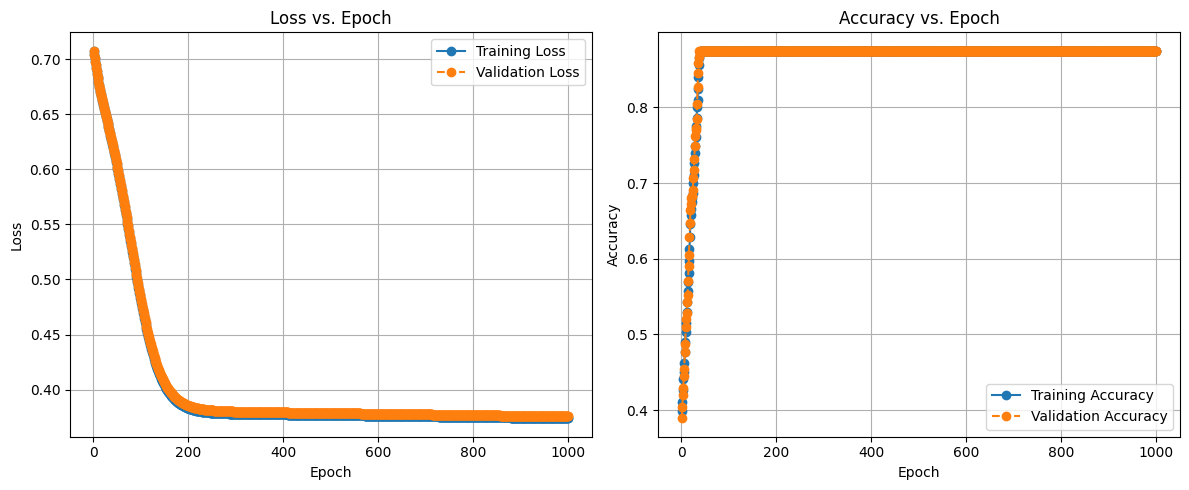

In [26]:
for epoch in range(1, 1001):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = test(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
class SimplePoseCNN(nn.Module):
    def __init__(self):
        super(SimplePoseCNN, self).__init__()
        # Assuming each point has 3 coordinates (x, y, z)
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(8 * 16, 32)  # Adjust based on the output size of the last conv layer
        self.fc2 = nn.Linear(32, 8)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation, if using BCEWithLogitsLoss
        return x

# Initialize the model and hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimplePoseCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.003)

# Lists to collect losses and accuracies for each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

total_epochs = 0
total_time = 0

In [ ]:
for epoch in range(1, 1001):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = test(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [18]:
# Get the current working directory
current_directory = os.getcwd()

# Define the file name for saving the model weights
model_weights_filename = 'model_weights.pth'

# Full path for saving the model weights
model_weights_path = os.path.join(current_directory, model_weights_filename)

# Save the model's state dictionary
torch.save(model.state_dict(), model_weights_path)

# Print the path to confirm saving
print(f"Model weights saved to {model_weights_path}")



Model weights saved to /Users/abhishekchothani/01 Study/04 EE CS/04.03 Artificial Intelligence/02 Code/00 Mirai Code/Mirai3_Drone_Gesture_Control/Models/model_weights.pth


In [19]:
# Replace this with your actual model file path
model_file_path = '/Users/abhishekchothani/01 Study/04 EE CS/04.03 Artificial Intelligence/02 Code/00 Mirai Code/Mirai3_Drone_Gesture_Control/Models/model_weights.pth'

# Attempt to load the model file
try:
    model_state_dict = torch.load(model_file_path)
    print("Model file loaded successfully.")
except Exception as e:
    print(f"Error loading model file: {e}")


Model file loaded successfully.
